## 1 — Recognize objects in image (or classify image)

Using trained NN, get object label or labels for image, or otherwise provide a label for the image. Also store the centrality of the object. 

## 2  — Generate semantic word families

For each label, use Word2Vec `similar` to retrieve list of words semantically related to the image object labels

## 3 — Generate all related words

For each semantically related (below a distance threshold) word to each object label, measure its phonetic similarity to all words in the dictionary. Also store each words's distance.

For each word in each semantic family, sort and choose the phonetically closest (below a distance threshold) words.
(One way is to convert the word to IPA and compare to an IPA converted version of every word in the CMU dictionary.)

## 4 — Gather candidate phrases

For each word in the phonetic family, of each word in the semantic family, of each object label, retrieve each idiom containing the word.
Add the idiom Id, as well as the stats on the object centrality, semantic distance, and phonetic distance, to a dataframe.

Compute _suitability score_ for each word-idiom match and add this to that column of the dataframe

Also, for each word in the semantic family, search the joke list for match and add that these to a joke_match dataframe, to use if there's too low a suitability score using a substitution.


## 5 — Choose captions

Sort captions dataframe by the _suitability score_

Choose the top 10 and generate a list containing each caption with the original semantic family word substituted into the idiom in addition to jokes containing any of the semantic family words

In [595]:
test_image_topic=  'two'
image_topic = test_image_topic

In [596]:
import pandas as pd
from collections import namedtuple
import uuid

## -1  — Webscrape and process phrases (idioms, sayings, aphorisms)

They should be converted into lists of phonetic sounds

## 0  — Load `phrase_dict` pickled and processed after being scraped

#### Data structures defined

In [597]:

Phrase = namedtuple('Phrase',['text_string', 'word_list','phon_list','string_length', 'word_count', 'prefix', 'phrase_type'])
phrase_dict = dict()

Close_word = namedtuple('Close_word', ['word', 'distance'])

Sem_family = namedtuple('Sem_family', ['locus_word', 'sem_fam_words'])

Phon_family = namedtuple('Phon_family', ['locus_word', 'close_words'])

#### Temporary toy example of the dict of phrases, to be replaced with idioms etc. scraped from web

In [598]:
t_string = 'Smarter than the average bear'
w_list = t_string.lower().split()
ph_id1 = uuid.uuid1()
phrase_dict[ph_id1] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

# toy example of the dict
t_string = 'Not a hair out of place'
w_list = t_string.lower().split()
ph_id2 = uuid.uuid1()
phrase_dict[ph_id2] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

# toy example of the dict
t_string = 'Three blind mice'
w_list = t_string.lower().split()
ph_id3 = uuid.uuid1()
phrase_dict[ph_id3] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

# toy example of the dict
t_string = 'I just called to say I love you'
w_list = t_string.lower().split()
ph_id4 = uuid.uuid1()
phrase_dict[ph_id4] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

t_string = 'Up, up in the air'
w_list = t_string.lower().split()
ph_id5 = uuid.uuid1()
phrase_dict[ph_id5] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

t_string = 'Wouldn\'t it be nice'
w_list = t_string.lower().split()
ph_id6 = uuid.uuid1()
phrase_dict[ph_id6] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

t_string = 'Roses are red, violets are blue'
w_list = t_string.lower().split()
ph_id7 = uuid.uuid1()
phrase_dict[ph_id7] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )



In [599]:
phrase_dict

{UUID('7a44aab8-8165-11eb-abae-acde48001122'): Phrase(text_string='Smarter than the average bear', word_list=['smarter', 'than', 'the', 'average', 'bear'], phon_list=['smarter', 'than', 'the', 'average', 'bear'], string_length=29, word_count=5, prefix='As usual: ', phrase_type='idiom'),
 UUID('7a44b1a2-8165-11eb-abae-acde48001122'): Phrase(text_string='Not a hair out of place', word_list=['not', 'a', 'hair', 'out', 'of', 'place'], phon_list=['not', 'a', 'hair', 'out', 'of', 'place'], string_length=23, word_count=6, prefix='As usual: ', phrase_type='idiom'),
 UUID('7a44b6e8-8165-11eb-abae-acde48001122'): Phrase(text_string='Three blind mice', word_list=['three', 'blind', 'mice'], phon_list=['three', 'blind', 'mice'], string_length=16, word_count=3, prefix='As usual: ', phrase_type='idiom'),
 UUID('7a44bbfc-8165-11eb-abae-acde48001122'): Phrase(text_string='I just called to say I love you', word_list=['i', 'just', 'called', 'to', 'say', 'i', 'love', 'you'], phon_list=['i', 'just', 'calle

In [600]:
# change this so that it imports into a pandas dataframe, so that we can import conversational 
# prefixes and suffixes manually editied in Excel

import csv
idiom_list = []
with open('data/idioms_1500.csv', 'r') as idioms_data: 
    for line in csv.reader(idioms_data):
        idiom_list.extend(line)
idiom_list = idiom_list[1:]
idiom_list


['a bit much',
 'a bite at the cherry',
 'a busy bee',
 'a cat has nine lives',
 'a cat in gloves catches no mice',
 'a cat nap',
 'a cold day in july',
 'a cold fish',
 'a cut above',
 'a cut below',
 'a day late and a dollar short',
 'a dog in the manger',
 'a few sandwiches short of a picnic',
 'a good deal',
 'a great dea',
 'a guinea pig',
 'a hair’s breadth',
 'a home bird',
 'a hundred and ten percent',
 'a lame duck',
 'a leg up',
 'a lemon',
 'a life of its own',
 'a little bird told me',
 'a little bird told me',
 'a little from column a, a little from column b',
 'a lone wolf',
 'a lot on one’s plate',
 'a million and one',
 'a notch above',
 'a penny for your thoughts',
 'a penny saved is a penny earned',
 'a picture is worth a thousand words',
 'a plum job',
 'a rare bird',
 'a scaredy-cat',
 'a second bite at the cherry',
 'a sight for sore eye',
 'a sitting duck',
 'a snowball’s chance in hell',
 'a stitch in time saves nine',
 'a stone’s throw',
 'a storm in a teacup',


In [601]:
for idiom_str in idiom_list:
    w_list = idiom_str.lower().split()
    phrase_dict[uuid.uuid1()] = Phrase(text_string = idiom_str, word_list = w_list, phon_list = w_list, string_length = len(idiom_str), word_count = len(w_list), prefix="Yeah, right, like  ", phrase_type='idiom' )


## 1 — Recognize objects in image (or classify image)

Using trained NN, get object label or labels for image, or otherwise provide a label for the image. Also store the centrality of the object. 

In [602]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tf_explain.core.activations import ExtractActivations
from tensorflow.keras.applications.xception import decode_predictions


%matplotlib inline

In [603]:
def prepare_image_classification_model():
    model_ = tf.keras.applications.xception.Xception(weights = 'imagenet', include_top=True)
    return model_

import requests
def get_image_category_labels():  # is this function even necessary?
    #fetching labels from Imagenet
    response=requests.get('https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json')
    imgnet_map=response.json()
    imgnet_map   # {'0': ['n01440764', 'tench'],   '1': ['n01443537', 'goldfish'], etc.
    
    imgnet_num_from_label = {v[1]:k for k, v in imgnet_map.items()}
    imgnet_label_from_num = {k:v[1] for k, v in imgnet_map.items()}

    return ( imgnet_num_from_label, imgnet_label_from_num ) 


In [604]:
def get_num_str( num, max_digits=4 ):
    leading_zeros = int(max_digits - (np.trunc(np.log10(num))+1))
    return '0'*leading_zeros + str(num)

In [605]:
import random

def get_image_path():
    path_prefix = 'data/ILSVRC/Data/DET/test/'
    filename_stem ='ILSVRC2017_test_0000'
    filename_suffix = '.JPEG'
    random.seed()
    file_number = rand_num = random.randint(1, 5500)   
    IMAGE_PATH_ = path_prefix + filename_stem + get_num_str( rand_num ) + filename_suffix
    return IMAGE_PATH_
    
def preprocess_image( IMAGE_PATH_ ):
    img_ =tf.keras.preprocessing.image.load_img(IMAGE_PATH_, target_size=(299, 299))
    img_ =tf.keras.preprocessing.image.img_to_array(img_)
    # prepare to show and save image
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.autoscale(tight=True)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(img_/255.)
    plt.savefig('data/temp.png',bbox_inches='tight')
    return img_ # It seems futile to return this image

def process_and_classify_image( img_, model_):
    img_ = tf.keras.applications.xception.preprocess_input(img_)
    print( 'img.shape: ', img_.shape )
    prediction_array = model_.predict(np.array([img_]))
    return prediction_array

def extract_best_prediction( prediction_array_ ):
    prediction_decoded = decode_predictions(prediction_array_, top=5)
    print( prediction_decoded )
    best_prediction_str = prediction_decoded[0][0][1]
    return best_prediction_str
    

In [606]:
#global_var_img = None

def image_recognition_pipeline( ):
    model = prepare_image_classification_model()
    get_image_category_labels()
    IMAGE_PATH = get_image_path()
    img = preprocess_image( IMAGE_PATH )
    prediction_array = process_and_classify_image( img, model)
    image_topic_ = extract_best_prediction( prediction_array )
    #global_var_img = img
    return  img, image_topic_

img.shape:  (299, 299, 3)
[[('n02672831', 'accordion', 0.2245125), ('n04141076', 'sax', 0.12814724), ('n02787622', 'banjo', 0.069178164), ('n03272010', 'electric_guitar', 0.06320568), ('n02676566', 'acoustic_guitar', 0.03512951)]]


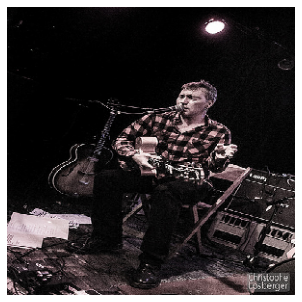

In [607]:
recognized_image, image_topic  = image_recognition_pipeline( )

In [608]:
#image_topic='dragonfly'

In [609]:
#plt.imshow(recognized_image/255.)

## 2 — Generate semantic word families

For each label, use Word2Vec `similar` to retrieve list of words semantically related to the image object labels

In [610]:
from nltk.corpus import wordnet

def get_synonyms( w ):
    #L = [l.name() if '_' not in l.name() else l.name().split('_') for l in wordnet.synsets( w )[0].lemmas()]  # There may be other synonyms in the synset
    #flattened_list = [w if type()]
    #return L #flattened_list
    return [word for object_name in [syn.name().split('_') for syn in wordnet.synsets( w )[0].lemmas()] for word in object_name]

In [611]:
get_synonyms( 'oystercatcher' )

['oystercatcher', 'oyster', 'catcher']

In [612]:
wordnet.synsets( 'oystercatcher' )[0].lemmas()
#get_synonyms( 'ladybug')

[Lemma('oystercatcher.n.01.oystercatcher'),
 Lemma('oystercatcher.n.01.oyster_catcher')]

## 3 — Generate all related words

For each semantically related (below a distance threshold) word to each object label, measure its phonetic similarity to all words in the dictionary. Also store each words's distance.

For each word in each semantic family, sort and choose the phonetically closest (below a distance threshold) words.
(One way is to convert the word to IPA and compare to an IPA converted version of every word in the CMU dictionary.)

In [613]:
#english_dictionary = ['two', 'pair', 'bear', 'scare', 'you', 'twice', 'hair', 'mice', 'speaker', 'book']

In [614]:
# two_phon_fam = Phon_family(locus_word=Close_word('two', 3), close_words = [Close_word('you', 2.1)])
# two_phon_fam

# pair_phon_fam = Phon_family(locus_word=Close_word('pair', 5), close_words = [Close_word('bear', 1.5), Close_word('hair', 2.7)])
# pair_phon_fam

# twice_phon_fam = Phon_family(locus_word=Close_word('twice', 4.1), close_words = [Close_word('mice', 2.1)])
# twice_phon_fam

In [615]:
from nltk.corpus import words

words_set = set( words.words())
english_dictionary = words_set

In [616]:
import eng_to_ipa as ipa

def syllable_count_diff( w1, w2 ):
    return abs( ipa.syllable_count( w1 ) - ipa.syllable_count( w2 ))

def same_syllable_count( w1, w2 ):
    return syllable_count_diff(w1, w2) == 0

def close_syllable_count( w1, w2, threshold=2):
    return syllable_count_diff( w1, w2 ) <= threshold

In [617]:
# Eventually will need to to filter for the word-frequency sweet-spot or at least for only Engllish words
# Possibly rewrite with a decororater so that it uses memoization to speed this up

# Rewrite this so it vectorizes the subtraction of the syllable counts

def get_sized_rhymes( w ):
    word_length_min = 2
    rhyme_list = ipa.get_rhymes( w )
    return [ [rhyme for rhyme  in rhyme_list if same_syllable_count( w, rhyme) and len(rhyme) >= word_length_min and rhyme in words_set]]
   

In [618]:
#ipa.isin_cmu('xue')

In [619]:
get_sized_rhymes('oyster')

[['cloister', 'foister', 'roister']]

In [641]:
import fuzzy
import phonetics
import Levenshtein as lev

soundex = fuzzy.Soundex(4)
dmeta = fuzzy.DMetaphone()

In [652]:
## Temporary stand-in function, to be replaced with one that computes phonetic distance

# https://stackabuse.com/phonetic-similarity-of-words-a-vectorized-approach-in-python/
# "Phonetic Similarity of Words: A Vectorized Approach in Python"

def phonetic_distance(w1, w2):
#     print('fuzzy soundex', lev.distance( soundex(w1), soundex(w2)) )
#     print('fuzzy dmeta  ', lev.distance( dmeta(w1)[0], dmeta(w2)[0]) )
#     print('phon dmet    ', lev.distance( phonetics.dmetaphone(w1)[0], phonetics.dmetaphone(w2)[0]) )
#     print('phon met     ', lev.distance( phonetics.metaphone(w1), phonetics.metaphone(w2)) )
#     print('fuzzy nysiis ', lev.distance( fuzzy.nysiis(w1), fuzzy.nysiis(w2)) )
#     print('phon nysiis  ', lev.distance( phonetics.nysiis(w1), phonetics.nysiis(w2)) )
#     soundex_dist = lev.distance( soundex(w1), soundex(w2))
    nysiis_dist = lev.distance( fuzzy.nysiis(w1), fuzzy.nysiis(w2))
    try:
        dmeta_dist  = lev.distance( dmeta(w1)[0], dmeta(w2)[0])
        return np.mean( np.array([  dmeta_dist, nysiis_dist]) )
    except:
        return nysiis_dist

In [653]:
from random import random


# Are these three lines necessary?
two_fam_member_list = ['you']
pair_fam_member_list = ['bear', 'hair']
twice_fam_member_list = ['mice']

def make_phon_fam_for_sem_fam_member( w_record, thresh=3 ):
    w_phon_code = w_record.word # To be replaced with phonetic version if needed
    close_word_list = []
    
    # Find words that are not necessarily rhyms but phonetically similar
    for word in words_set:
        phon_dist = phonetic_distance( word, w_record.word) 
        if phon_dist <= thresh:
            close_word_list.append( Close_word(word.lower(), phon_dist ))
    
    rhyme_dist = .5
    rhyme_word_list = get_sized_rhymes( w_record.word )[0]
    
    # Find words that are rhymes
    for word in rhyme_word_list:
         close_word_list.append( Close_word(word, rhyme_dist) )
    
    
    return Phon_family(locus_word = w_record, close_words=close_word_list )
    
    

In [654]:
# two_phon_fam = get_phon_fam_for_sem_fam_member( 'two' )
# pair_phon_fam = get_phon_fam_for_sem_fam_member( 'pair' )
# twice_phon_fam = get_phon_fam_for_sem_fam_member( 'twice' )


In [655]:
## ALERT:  Need to incorporate the semantic distance somewhere

In [656]:
# two_sem_fam = Sem_family(locus_word='two', phon_fams = [make_phon_fam_for_sem_fam_member( 'two' ), \
#                                                         make_phon_fam_for_sem_fam_member( 'pair' ), \
#                                                         make_phon_fam_for_sem_fam_member( 'twice' )])

In [657]:
# To be replaced with Word2Vec `most_similar()`

def get_most_similar_obsolete( w ):  
    list_of_duples =  [('pair', .95), ('twice', .90)]
    list_of_close_words = [Close_word( word=w_str, distance= 1 - w_sim) for w_str, w_sim in list_of_duples ]
        
    return list_of_close_words

In [658]:
def get_most_similar( w ):  
    synonym_dist_setting = .6
    list_of_duples = [(syn, synonym_dist_setting) for syn in get_synonyms( w )]
    if(w == 'two'):
        additional_words =  [('pair', .95), ('twice', .90)]
        list_of_duples.extend( additional_words )
    list_of_close_words = [Close_word( word=w_str, distance= w_sim) for w_str, w_sim in list_of_duples ]
        
    return list_of_close_words

In [659]:
get_most_similar( 'oyster' )

[Close_word(word='oyster', distance=0)]

In [660]:
def make_phon_fams_and_sem_family( w ):
    word_record_ = Close_word(w, 0.0)
    
    sem_sim_words = get_most_similar( w )  # Eventually replace with call to Word2Vec
    
    #phon_fams_list = [make_phon_fam_for_sem_fam_member( word_record_  )]
    phon_fams_list = []

    
    for close_w_record in sem_sim_words:
        print( close_w_record )
        phon_fams_list.append( make_phon_fam_for_sem_fam_member( close_w_record ) )
    
    return Sem_family(locus_word= word_record_, sem_fam_words = phon_fams_list)
   
 

In [661]:
make_phon_fams_and_sem_family('soccer')

Close_word(word='soccer', distance=0)
Close_word(word='association', distance=0)
Close_word(word='football', distance=0)


Sem_family(locus_word=Close_word(word='soccer', distance=0.0), sem_fam_words=[Phon_family(locus_word=Close_word(word='soccer', distance=0), close_words=[Close_word(word='hickory', distance=2.0), Close_word(word='rumorous', distance=2.5), Close_word(word='cartier', distance=3.0), Close_word(word='geoduck', distance=3.0), Close_word(word='superhive', distance=2.5), Close_word(word='zincite', distance=3.0), Close_word(word='squacco', distance=2.5), Close_word(word='fictile', distance=3.0), Close_word(word='sarong', distance=3.0), Close_word(word='sexed', distance=2.5), Close_word(word='thecal', distance=2.5), Close_word(word='chudic', distance=3.0), Close_word(word='studium', distance=3.0), Close_word(word='mydaidae', distance=3.0), Close_word(word='phosphoruria', distance=3.0), Close_word(word='stadic', distance=3.0), Close_word(word='sillock', distance=2.0), Close_word(word='gorer', distance=2.0), Close_word(word='somnify', distance=3.0), Close_word(word='ratafia', distance=3.0), Close_

In [662]:
# two_sem_fam = make_phon_fams_and_sem_family('two')
# two_sem_fam

## 4 — Gather candidate phrases

For each word in the phonetic family, of each word in the semantic family, of each object label, retrieve phrases containing the word.
Add the phrase_Id, as well as the stats on the object centrality, semantic distance, and phonetic distance, to a dataframe.

Compute _suitability score_ for each word-phrase match and add this to that column of the dataframe

Also, for each word in the semantic family, search the joke list for match and add that these to a joke_match dataframe, to use if there's too low a suitability score using a substitution.


In [663]:
get_most_similar('soccer')

[Close_word(word='soccer', distance=0),
 Close_word(word='association', distance=0),
 Close_word(word='football', distance=0)]

## TO CODE NEXT

Write code that takes the word `twice` and returns its `semantic_family` which is a list of words 
('pair', and 'twice' in this case) and returns either (TBD) the list phonetically similar words or 
the pboneticized version of the word to be compared with the phoneticized variants of words in
the phrases



#### Define dataframe for candidate phrases

In [664]:
col_names = ['semantic_match', 'sem_dist', 'phonetic_match', 'phon_dist', 'phrase_id', 'score']

cand_df = pd.DataFrame(columns= col_names)
cand_df

Empty DataFrame
Columns: [semantic_match, sem_dist, phonetic_match, phon_dist, phrase_id, score]
Index: []

#### Need to write body of function that will convert to phoneticized version of word

In [665]:
def phoneticized( w ):
    return w

### ALERT:  Instead, pre-generate a dictionary of phoneticized versions of the words in the list of idioms. Each phonetic word should map to a list of duples each of which is a phrase id and the corresponding word

In [666]:
def get_matching_phrases( w ):
    matched_id_list = []
    for phrase_id in phrase_dict.keys():
        if w in phrase_dict[phrase_id].phon_list:
            matched_id_list.append(phrase_id)
            print( phrase_dict[ phrase_id] )
            return matched_id_list

In [667]:
get_matching_phrases('oyster') 

Phrase(text_string='the world is your oyster', word_list=['the', 'world', 'is', 'your', 'oyster'], phon_list=['the', 'world', 'is', 'your', 'oyster'], string_length=24, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')


[UUID('7b1481f2-8165-11eb-abae-acde48001122')]

In [668]:
#  cycles through each phonetic family in the semantic family to get matching phrases

#def get_phrases_for_phon_fam( phon_fam_, sem_dist_ ):
def get_phrases_for_phon_fam( phon_fam_ ):

    word_match_records_ = []

    #phon_fam_ = pair_phon_fam
    for word in phon_fam_.close_words:
        matched_phrases = get_matching_phrases( word.word )
        #print(word, len(matched_phrases))
        if matched_phrases:
            for p_id in matched_phrases:
                word_match_records_.append({'semantic_match': phon_fam_.locus_word.word, 'sem_dist': phon_fam_.locus_word.distance, 'phonetic_match': word.word, 'phon_dist': word.distance, 'phrase_id': p_id, 'score': ''})
    return word_match_records_ 


In [669]:
def get_phrases_for_sem_fam( sem_fam_ ):
    word_match_records_ = []
    for phon_fam_ in sem_fam_.sem_fam_words:
        print( phon_fam_.locus_word.distance )
        #word_match_records_.extend( get_phrases_for_phon_fam( phon_fam_, sem_fam_.locus_word.distance ) )
        phrases_ = get_phrases_for_phon_fam( phon_fam_ ) 

        if len( phrases_ ) > 0:
            print( phrases_ )
            word_match_records_.extend( phrases_ )
    return word_match_records_

In [670]:
# word_match_records = []   

# word_match_records.extend( get_phrases_for_phon_fam( two_phon_fam ) ) 
# word_match_records.extend( get_phrases_for_phon_fam( pair_phon_fam ) )
# word_match_records.extend( get_phrases_for_phon_fam( twice_phon_fam ) )  
# word_match_records

In [671]:
#cand_df = cand_df.append(word_match_records)

In [672]:
#two_sem_fam

In [673]:
# word_match_records = get_phrases_for_sem_fam( two_sem_fam )
# word_match_records

In [674]:
# To be replaced with image recognition algorithms
def get_image_topics():
    return [image_topic]
    #return [test_image_topic]

## The equivalent of `main` for the time being, until two or more image topics are handled

In [675]:
image_topics     = get_image_topics()
image_topic_word = image_topics[0]
#image_topic_word = 'boy'

image_sem_fam = make_phon_fams_and_sem_family( image_topic_word )
#two_sem_fam

word_match_records = get_phrases_for_sem_fam( image_sem_fam )

cand_df = cand_df.append(word_match_records)

Close_word(word='accordion', distance=0)
Close_word(word='piano', distance=0)
Close_word(word='accordion', distance=0)
Close_word(word='squeeze', distance=0)
Close_word(word='box', distance=0)
0
Phrase(text_string='get the sack, be sacked', word_list=['get', 'the', 'sack,', 'be', 'sacked'], phon_list=['get', 'the', 'sack,', 'be', 'sacked'], string_length=23, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='throw caution to the wind', word_list=['throw', 'caution', 'to', 'the', 'wind'], phon_list=['throw', 'caution', 'to', 'the', 'wind'], string_length=25, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a second bite at the cherry', word_list=['a', 'second', 'bite', 'at', 'the', 'cherry'], phon_list=['a', 'second', 'bite', 'at', 'the', 'cherry'], string_length=27, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='arm candy', word_list=['arm', 'candy'], phon_list=['arm', 'candy'], 

Phrase(text_string='brush under the carpet', word_list=['brush', 'under', 'the', 'carpet'], phon_list=['brush', 'under', 'the', 'carpet'], string_length=22, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='changing of the guard', word_list=['changing', 'of', 'the', 'guard'], phon_list=['changing', 'of', 'the', 'guard'], string_length=21, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='green around the gills', word_list=['green', 'around', 'the', 'gills'], phon_list=['green', 'around', 'the', 'gills'], string_length=22, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='no holds barred', word_list=['no', 'holds', 'barred'], phon_list=['no', 'holds', 'barred'], string_length=15, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a tall order', word_list=['a', 'tall', 'order'], phon_list=['a', 'tall', 'order'], string_length=12, word_count=3, prefix=

Phrase(text_string='feast your eyes on', word_list=['feast', 'your', 'eyes', 'on'], phon_list=['feast', 'your', 'eyes', 'on'], string_length=18, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='burn the midnight oil', word_list=['burn', 'the', 'midnight', 'oil'], phon_list=['burn', 'the', 'midnight', 'oil'], string_length=21, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a few sandwiches short of a picnic', word_list=['a', 'few', 'sandwiches', 'short', 'of', 'a', 'picnic'], phon_list=['a', 'few', 'sandwiches', 'short', 'of', 'a', 'picnic'], string_length=34, word_count=7, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='all bets are off', word_list=['all', 'bets', 'are', 'off'], phon_list=['all', 'bets', 'are', 'off'], string_length=16, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='and so forth', word_list=['and', 'so', 'forth'], phon_list=['and', 'so'

Phrase(text_string='arm candy', word_list=['arm', 'candy'], phon_list=['arm', 'candy'], string_length=9, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='slam dunk', word_list=['slam', 'dunk'], phon_list=['slam', 'dunk'], string_length=9, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='stab someone in the back', word_list=['stab', 'someone', 'in', 'the', 'back'], phon_list=['stab', 'someone', 'in', 'the', 'back'], string_length=24, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='drag one’s feet (or heels)', word_list=['drag', 'one’s', 'feet', '(or', 'heels)'], phon_list=['drag', 'one’s', 'feet', '(or', 'heels)'], string_length=26, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a cold fish', word_list=['a', 'cold', 'fish'], phon_list=['a', 'cold', 'fish'], string_length=11, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phr

Phrase(text_string='grab (take) the bull by the horns', word_list=['grab', '(take)', 'the', 'bull', 'by', 'the', 'horns'], phon_list=['grab', '(take)', 'the', 'bull', 'by', 'the', 'horns'], string_length=33, word_count=7, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='take a deep dive (into)', word_list=['take', 'a', 'deep', 'dive', '(into)'], phon_list=['take', 'a', 'deep', 'dive', '(into)'], string_length=23, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='stand (someone) in good stead', word_list=['stand', '(someone)', 'in', 'good', 'stead'], phon_list=['stand', '(someone)', 'in', 'good', 'stead'], string_length=29, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='go ape', word_list=['go', 'ape'], phon_list=['go', 'ape'], string_length=6, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='I just called to say I love you', word_list=['i', 'just', 'called'

Phrase(text_string='this has (person x) written all over it', word_list=['this', 'has', '(person', 'x)', 'written', 'all', 'over', 'it'], phon_list=['this', 'has', '(person', 'x)', 'written', 'all', 'over', 'it'], string_length=39, word_count=8, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a home bird', word_list=['a', 'home', 'bird'], phon_list=['a', 'home', 'bird'], string_length=11, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='elevator pitch', word_list=['elevator', 'pitch'], phon_list=['elevator', 'pitch'], string_length=14, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='dog days of the summer', word_list=['dog', 'days', 'of', 'the', 'summer'], phon_list=['dog', 'days', 'of', 'the', 'summer'], string_length=22, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='all bark and no bite', word_list=['all', 'bark', 'and', 'no', 'bite'], phon_list=['all

Phrase(text_string='tip of the iceberg', word_list=['tip', 'of', 'the', 'iceberg'], phon_list=['tip', 'of', 'the', 'iceberg'], string_length=18, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='green as grass', word_list=['green', 'as', 'grass'], phon_list=['green', 'as', 'grass'], string_length=14, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='let the genie out of the bottle', word_list=['let', 'the', 'genie', 'out', 'of', 'the', 'bottle'], phon_list=['let', 'the', 'genie', 'out', 'of', 'the', 'bottle'], string_length=31, word_count=7, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='come out in the wash', word_list=['come', 'out', 'in', 'the', 'wash'], phon_list=['come', 'out', 'in', 'the', 'wash'], string_length=20, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='beyond the shadow of a doubt', word_list=['beyond', 'the', 'shadow', 'of', 'a', 'doubt'],

Phrase(text_string='a bite at the cherry', word_list=['a', 'bite', 'at', 'the', 'cherry'], phon_list=['a', 'bite', 'at', 'the', 'cherry'], string_length=20, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='pure as the driven snow', word_list=['pure', 'as', 'the', 'driven', 'snow'], phon_list=['pure', 'as', 'the', 'driven', 'snow'], string_length=23, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a picture is worth a thousand words', word_list=['a', 'picture', 'is', 'worth', 'a', 'thousand', 'words'], phon_list=['a', 'picture', 'is', 'worth', 'a', 'thousand', 'words'], string_length=35, word_count=7, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='high as a kite', word_list=['high', 'as', 'a', 'kite'], phon_list=['high', 'as', 'a', 'kite'], string_length=14, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='keeping one’s nose to the grindstone', word_list=[

Phrase(text_string='take the edge off (of something', word_list=['take', 'the', 'edge', 'off', '(of', 'something'], phon_list=['take', 'the', 'edge', 'off', '(of', 'something'], string_length=31, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='fox in the henhouse (chickenhouse)', word_list=['fox', 'in', 'the', 'henhouse', '(chickenhouse)'], phon_list=['fox', 'in', 'the', 'henhouse', '(chickenhouse)'], string_length=34, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='strike a chord', word_list=['strike', 'a', 'chord'], phon_list=['strike', 'a', 'chord'], string_length=14, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='look the other way', word_list=['look', 'the', 'other', 'way'], phon_list=['look', 'the', 'other', 'way'], string_length=18, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='all hat and no cattle', word_list=['all', 'hat', 'and

Phrase(text_string='to be a peach', word_list=['to', 'be', 'a', 'peach'], phon_list=['to', 'be', 'a', 'peach'], string_length=13, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='cash in one’s chips', word_list=['cash', 'in', 'one’s', 'chips'], phon_list=['cash', 'in', 'one’s', 'chips'], string_length=19, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='bang for your buck', word_list=['bang', 'for', 'your', 'buck'], phon_list=['bang', 'for', 'your', 'buck'], string_length=18, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a hundred and ten percent', word_list=['a', 'hundred', 'and', 'ten', 'percent'], phon_list=['a', 'hundred', 'and', 'ten', 'percent'], string_length=25, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='in the nick of time', word_list=['in', 'the', 'nick', 'of', 'time'], phon_list=['in', 'the', 'nick', 'of', 'time'], string_le

Phrase(text_string='borrow trouble', word_list=['borrow', 'trouble'], phon_list=['borrow', 'trouble'], string_length=14, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='after the lord mayor’s show (uk)', word_list=['after', 'the', 'lord', 'mayor’s', 'show', '(uk)'], phon_list=['after', 'the', 'lord', 'mayor’s', 'show', '(uk)'], string_length=32, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='as red as a cherry', word_list=['as', 'red', 'as', 'a', 'cherry'], phon_list=['as', 'red', 'as', 'a', 'cherry'], string_length=18, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='boys will be boys', word_list=['boys', 'will', 'be', 'boys'], phon_list=['boys', 'will', 'be', 'boys'], string_length=17, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='and then some', word_list=['and', 'then', 'some'], phon_list=['and', 'then', 'some'], string_length=13, wor

Phrase(text_string='an apple a day keeps the doctor away', word_list=['an', 'apple', 'a', 'day', 'keeps', 'the', 'doctor', 'away'], phon_list=['an', 'apple', 'a', 'day', 'keeps', 'the', 'doctor', 'away'], string_length=36, word_count=8, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='best (greatest) thing since sliced bread', word_list=['best', '(greatest)', 'thing', 'since', 'sliced', 'bread'], phon_list=['best', '(greatest)', 'thing', 'since', 'sliced', 'bread'], string_length=40, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='chew the fat', word_list=['chew', 'the', 'fat'], phon_list=['chew', 'the', 'fat'], string_length=12, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string="Wouldn't it be nice", word_list=["wouldn't", 'it', 'be', 'nice'], phon_list=["wouldn't", 'it', 'be', 'nice'], string_length=19, word_count=4, prefix='As usual: ', phrase_type='idiom')
Phrase(text_string='a leg up', wor

Phrase(text_string='zero in on', word_list=['zero', 'in', 'on'], phon_list=['zero', 'in', 'on'], string_length=10, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='cat got your tongue?', word_list=['cat', 'got', 'your', 'tongue?'], phon_list=['cat', 'got', 'your', 'tongue?'], string_length=20, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='new wrinkle', word_list=['new', 'wrinkle'], phon_list=['new', 'wrinkle'], string_length=11, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='price yourself out of the market', word_list=['price', 'yourself', 'out', 'of', 'the', 'market'], phon_list=['price', 'yourself', 'out', 'of', 'the', 'market'], string_length=32, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='join the club (excl.)', word_list=['join', 'the', 'club', '(excl.)'], phon_list=['join', 'the', 'club', '(excl.)'], string_length=21, word_coun

Phrase(text_string='don’t cry over spilled milk', word_list=['don’t', 'cry', 'over', 'spilled', 'milk'], phon_list=['don’t', 'cry', 'over', 'spilled', 'milk'], string_length=27, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a little bird told me', word_list=['a', 'little', 'bird', 'told', 'me'], phon_list=['a', 'little', 'bird', 'told', 'me'], string_length=21, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='hold one’s peace', word_list=['hold', 'one’s', 'peace'], phon_list=['hold', 'one’s', 'peace'], string_length=16, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='buy a pig in a poke', word_list=['buy', 'a', 'pig', 'in', 'a', 'poke'], phon_list=['buy', 'a', 'pig', 'in', 'a', 'poke'], string_length=19, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='cry over spilt (usa: spilled)', word_list=['cry', 'over', 'spilt', '(usa:', 'spilled)'], 

Phrase(text_string='black and white', word_list=['black', 'and', 'white'], phon_list=['black', 'and', 'white'], string_length=15, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='don’t look a gift horse in the mouth', word_list=['don’t', 'look', 'a', 'gift', 'horse', 'in', 'the', 'mouth'], phon_list=['don’t', 'look', 'a', 'gift', 'horse', 'in', 'the', 'mouth'], string_length=36, word_count=8, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='against the run of play', word_list=['against', 'the', 'run', 'of', 'play'], phon_list=['against', 'the', 'run', 'of', 'play'], string_length=23, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='bad blood', word_list=['bad', 'blood'], phon_list=['bad', 'blood'], string_length=9, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='hold one’s liquor', word_list=['hold', 'one’s', 'liquor'], phon_list=['hold', 'one’s', 'liquor']

Phrase(text_string='rotten to the core', word_list=['rotten', 'to', 'the', 'core'], phon_list=['rotten', 'to', 'the', 'core'], string_length=18, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='the jig is up', word_list=['the', 'jig', 'is', 'up'], phon_list=['the', 'jig', 'is', 'up'], string_length=13, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='spare the rod and spoil the child', word_list=['spare', 'the', 'rod', 'and', 'spoil', 'the', 'child'], phon_list=['spare', 'the', 'rod', 'and', 'spoil', 'the', 'child'], string_length=33, word_count=7, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='seize (take) the bull by the horns', word_list=['seize', '(take)', 'the', 'bull', 'by', 'the', 'horns'], phon_list=['seize', '(take)', 'the', 'bull', 'by', 'the', 'horns'], string_length=34, word_count=7, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='best (greatest) thing sinc

Phrase(text_string='not one’s cup of tea', word_list=['not', 'one’s', 'cup', 'of', 'tea'], phon_list=['not', 'one’s', 'cup', 'of', 'tea'], string_length=20, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='powder keg', word_list=['powder', 'keg'], phon_list=['powder', 'keg'], string_length=10, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='any port in a storm', word_list=['any', 'port', 'in', 'a', 'storm'], phon_list=['any', 'port', 'in', 'a', 'storm'], string_length=19, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='start with a clean slate', word_list=['start', 'with', 'a', 'clean', 'slate'], phon_list=['start', 'with', 'a', 'clean', 'slate'], string_length=24, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='Three blind mice', word_list=['three', 'blind', 'mice'], phon_list=['three', 'blind', 'mice'], string_length=16, word_count=3, pref

Phrase(text_string='and the like', word_list=['and', 'the', 'like'], phon_list=['and', 'the', 'like'], string_length=12, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a cat in gloves catches no mice', word_list=['a', 'cat', 'in', 'gloves', 'catches', 'no', 'mice'], phon_list=['a', 'cat', 'in', 'gloves', 'catches', 'no', 'mice'], string_length=31, word_count=7, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='the more things change, the more they stay the same', word_list=['the', 'more', 'things', 'change,', 'the', 'more', 'they', 'stay', 'the', 'same'], phon_list=['the', 'more', 'things', 'change,', 'the', 'more', 'they', 'stay', 'the', 'same'], string_length=51, word_count=10, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='blue eyed boy', word_list=['blue', 'eyed', 'boy'], phon_list=['blue', 'eyed', 'boy'], string_length=13, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_

Phrase(text_string='puppy dog eyes', word_list=['puppy', 'dog', 'eyes'], phon_list=['puppy', 'dog', 'eyes'], string_length=14, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='wake up and smell the coffee', word_list=['wake', 'up', 'and', 'smell', 'the', 'coffee'], phon_list=['wake', 'up', 'and', 'smell', 'the', 'coffee'], string_length=28, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='in a new york minute', word_list=['in', 'a', 'new', 'york', 'minute'], phon_list=['in', 'a', 'new', 'york', 'minute'], string_length=20, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='he would put legs under a chicken', word_list=['he', 'would', 'put', 'legs', 'under', 'a', 'chicken'], phon_list=['he', 'would', 'put', 'legs', 'under', 'a', 'chicken'], string_length=33, word_count=7, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='boy toy', word_list=['boy', 'toy'], phon_

Phrase(text_string='get off scot free', word_list=['get', 'off', 'scot', 'free'], phon_list=['get', 'off', 'scot', 'free'], string_length=17, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a lone wolf', word_list=['a', 'lone', 'wolf'], phon_list=['a', 'lone', 'wolf'], string_length=11, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='have your thumb up your ass', word_list=['have', 'your', 'thumb', 'up', 'your', 'ass'], phon_list=['have', 'your', 'thumb', 'up', 'your', 'ass'], string_length=27, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='up a creek', word_list=['up', 'a', 'creek'], phon_list=['up', 'a', 'creek'], string_length=10, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='shake the dust off your shoes (feet)', word_list=['shake', 'the', 'dust', 'off', 'your', 'shoes', '(feet)'], phon_list=['shake', 'the', 'dust', 'off', 'your', 's

Phrase(text_string='break up/ split up', word_list=['break', 'up/', 'split', 'up'], phon_list=['break', 'up/', 'split', 'up'], string_length=18, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='blank check', word_list=['blank', 'check'], phon_list=['blank', 'check'], string_length=11, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='be in seventh heaven', word_list=['be', 'in', 'seventh', 'heaven'], phon_list=['be', 'in', 'seventh', 'heaven'], string_length=20, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='step up one’s game', word_list=['step', 'up', 'one’s', 'game'], phon_list=['step', 'up', 'one’s', 'game'], string_length=18, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='basket case', word_list=['basket', 'case'], phon_list=['basket', 'case'], string_length=11, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(tex

Phrase(text_string='da man (slang)', word_list=['da', 'man', '(slang)'], phon_list=['da', 'man', '(slang)'], string_length=14, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='scare the living daylights out of someone', word_list=['scare', 'the', 'living', 'daylights', 'out', 'of', 'someone'], phon_list=['scare', 'the', 'living', 'daylights', 'out', 'of', 'someone'], string_length=41, word_count=7, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='Up, up in the air', word_list=['up,', 'up', 'in', 'the', 'air'], phon_list=['up,', 'up', 'in', 'the', 'air'], string_length=17, word_count=5, prefix='As usual: ', phrase_type='idiom')
Phrase(text_string='take it easy', word_list=['take', 'it', 'easy'], phon_list=['take', 'it', 'easy'], string_length=12, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='take a flyer', word_list=['take', 'a', 'flyer'], phon_list=['take', 'a', 'flyer'], string_length=12, 

Phrase(text_string='til the cows come home', word_list=['til', 'the', 'cows', 'come', 'home'], phon_list=['til', 'the', 'cows', 'come', 'home'], string_length=22, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='raise (someone’s) hackles', word_list=['raise', '(someone’s)', 'hackles'], phon_list=['raise', '(someone’s)', 'hackles'], string_length=25, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='take someone to task', word_list=['take', 'someone', 'to', 'task'], phon_list=['take', 'someone', 'to', 'task'], string_length=20, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='man cave', word_list=['man', 'cave'], phon_list=['man', 'cave'], string_length=8, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='I just called to say I love you', word_list=['i', 'just', 'called', 'to', 'say', 'i', 'love', 'you'], phon_list=['i', 'just', 'called', 'to', 's

Phrase(text_string='accident waiting to happen', word_list=['accident', 'waiting', 'to', 'happen'], phon_list=['accident', 'waiting', 'to', 'happen'], string_length=26, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='under someone’s spell', word_list=['under', 'someone’s', 'spell'], phon_list=['under', 'someone’s', 'spell'], string_length=21, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='have one foot in the grave', word_list=['have', 'one', 'foot', 'in', 'the', 'grave'], phon_list=['have', 'one', 'foot', 'in', 'the', 'grave'], string_length=26, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='in one fell swoop', word_list=['in', 'one', 'fell', 'swoop'], phon_list=['in', 'one', 'fell', 'swoop'], string_length=17, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='jack of all trades', word_list=['jack', 'of', 'all', 'trades'], phon_list=['jack

Phrase(text_string='a cold day in july', word_list=['a', 'cold', 'day', 'in', 'july'], phon_list=['a', 'cold', 'day', 'in', 'july'], string_length=18, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='witch hunt', word_list=['witch', 'hunt'], phon_list=['witch', 'hunt'], string_length=10, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='in the pipeline', word_list=['in', 'the', 'pipeline'], phon_list=['in', 'the', 'pipeline'], string_length=15, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='pass with flying colors', word_list=['pass', 'with', 'flying', 'colors'], phon_list=['pass', 'with', 'flying', 'colors'], string_length=23, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='that’s all she wrote', word_list=['that’s', 'all', 'she', 'wrote'], phon_list=['that’s', 'all', 'she', 'wrote'], string_length=20, word_count=4, prefix='Yeah, right, like

Phrase(text_string='red tape', word_list=['red', 'tape'], phon_list=['red', 'tape'], string_length=8, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='jump in with both feet', word_list=['jump', 'in', 'with', 'both', 'feet'], phon_list=['jump', 'in', 'with', 'both', 'feet'], string_length=22, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='between a rock and a hard place', word_list=['between', 'a', 'rock', 'and', 'a', 'hard', 'place'], phon_list=['between', 'a', 'rock', 'and', 'a', 'hard', 'place'], string_length=31, word_count=7, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='pot calling the kettle black', word_list=['pot', 'calling', 'the', 'kettle', 'black'], phon_list=['pot', 'calling', 'the', 'kettle', 'black'], string_length=28, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='above and beyond', word_list=['above', 'and', 'beyond'], phon_list=['abo

Phrase(text_string='a second bite at the cherry', word_list=['a', 'second', 'bite', 'at', 'the', 'cherry'], phon_list=['a', 'second', 'bite', 'at', 'the', 'cherry'], string_length=27, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='arm candy', word_list=['arm', 'candy'], phon_list=['arm', 'candy'], string_length=9, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='accident of birth', word_list=['accident', 'of', 'birth'], phon_list=['accident', 'of', 'birth'], string_length=17, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='close, but no cigar', word_list=['close,', 'but', 'no', 'cigar'], phon_list=['close,', 'but', 'no', 'cigar'], string_length=19, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='carry a torch (for)', word_list=['carry', 'a', 'torch', '(for)'], phon_list=['carry', 'a', 'torch', '(for)'], string_length=19, word_count=4, prefi

Phrase(text_string='a tall order', word_list=['a', 'tall', 'order'], phon_list=['a', 'tall', 'order'], string_length=12, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='arm candy', word_list=['arm', 'candy'], phon_list=['arm', 'candy'], string_length=9, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='acknowledge the corn', word_list=['acknowledge', 'the', 'corn'], phon_list=['acknowledge', 'the', 'corn'], string_length=20, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='spin a yarn', word_list=['spin', 'a', 'yarn'], phon_list=['spin', 'a', 'yarn'], string_length=11, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='another nail in one’s coffin', word_list=['another', 'nail', 'in', 'one’s', 'coffin'], phon_list=['another', 'nail', 'in', 'one’s', 'coffin'], string_length=28, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phras

Phrase(text_string='feast your eyes on', word_list=['feast', 'your', 'eyes', 'on'], phon_list=['feast', 'your', 'eyes', 'on'], string_length=18, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='burn the midnight oil', word_list=['burn', 'the', 'midnight', 'oil'], phon_list=['burn', 'the', 'midnight', 'oil'], string_length=21, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='and so forth', word_list=['and', 'so', 'forth'], phon_list=['and', 'so', 'forth'], string_length=12, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='an offer one can’t refuse', word_list=['an', 'offer', 'one', 'can’t', 'refuse'], phon_list=['an', 'offer', 'one', 'can’t', 'refuse'], string_length=25, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='strike a chord', word_list=['strike', 'a', 'chord'], phon_list=['strike', 'a', 'chord'], string_length=14, word_count=3, prefix=

Phrase(text_string='an offer one can’t refuse', word_list=['an', 'offer', 'one', 'can’t', 'refuse'], phon_list=['an', 'offer', 'one', 'can’t', 'refuse'], string_length=25, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='banner year', word_list=['banner', 'year'], phon_list=['banner', 'year'], string_length=11, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='slam dunk', word_list=['slam', 'dunk'], phon_list=['slam', 'dunk'], string_length=9, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='stab someone in the back', word_list=['stab', 'someone', 'in', 'the', 'back'], phon_list=['stab', 'someone', 'in', 'the', 'back'], string_length=24, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='drag one’s feet (or heels)', word_list=['drag', 'one’s', 'feet', '(or', 'heels)'], phon_list=['drag', 'one’s', 'feet', '(or', 'heels)'], string_length=26, word_co

Phrase(text_string='ahead of the game', word_list=['ahead', 'of', 'the', 'game'], phon_list=['ahead', 'of', 'the', 'game'], string_length=17, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='in touch', word_list=['in', 'touch'], phon_list=['in', 'touch'], string_length=8, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='i’ve had it up to here', word_list=['i’ve', 'had', 'it', 'up', 'to', 'here'], phon_list=['i’ve', 'had', 'it', 'up', 'to', 'here'], string_length=22, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='pet peeve', word_list=['pet', 'peeve'], phon_list=['pet', 'peeve'], string_length=9, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='i wouldn’t put it past (someone)', word_list=['i', 'wouldn’t', 'put', 'it', 'past', '(someone)'], phon_list=['i', 'wouldn’t', 'put', 'it', 'past', '(someone)'], string_length=32, word_count=6, prefix='Y

Phrase(text_string='saving grace', word_list=['saving', 'grace'], phon_list=['saving', 'grace'], string_length=12, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='cock and bull story', word_list=['cock', 'and', 'bull', 'story'], phon_list=['cock', 'and', 'bull', 'story'], string_length=19, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='bang one’s head against the wall (against a brick wall)', word_list=['bang', 'one’s', 'head', 'against', 'the', 'wall', '(against', 'a', 'brick', 'wall)'], phon_list=['bang', 'one’s', 'head', 'against', 'the', 'wall', '(against', 'a', 'brick', 'wall)'], string_length=55, word_count=10, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='lower the boom', word_list=['lower', 'the', 'boom'], phon_list=['lower', 'the', 'boom'], string_length=14, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='foul play', word_list=['foul', 'play'

Phrase(text_string='a bite at the cherry', word_list=['a', 'bite', 'at', 'the', 'cherry'], phon_list=['a', 'bite', 'at', 'the', 'cherry'], string_length=20, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='pure as the driven snow', word_list=['pure', 'as', 'the', 'driven', 'snow'], phon_list=['pure', 'as', 'the', 'driven', 'snow'], string_length=23, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='high as a kite', word_list=['high', 'as', 'a', 'kite'], phon_list=['high', 'as', 'a', 'kite'], string_length=14, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='make ends meet', word_list=['make', 'ends', 'meet'], phon_list=['make', 'ends', 'meet'], string_length=14, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='show me an x and i’ll show you a y', word_list=['show', 'me', 'an', 'x', 'and', 'i’ll', 'show', 'you', 'a', 'y'], phon_list=['show', 'me'

Phrase(text_string='chin up/ keep your chin up', word_list=['chin', 'up/', 'keep', 'your', 'chin', 'up'], phon_list=['chin', 'up/', 'keep', 'your', 'chin', 'up'], string_length=26, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='beat around the bush', word_list=['beat', 'around', 'the', 'bush'], phon_list=['beat', 'around', 'the', 'bush'], string_length=20, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='add fuel to the fire', word_list=['add', 'fuel', 'to', 'the', 'fire'], phon_list=['add', 'fuel', 'to', 'the', 'fire'], string_length=20, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='like two peas in a pod', word_list=['like', 'two', 'peas', 'in', 'a', 'pod'], phon_list=['like', 'two', 'peas', 'in', 'a', 'pod'], string_length=22, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='if the shoe fits, wear it', word_list=['if', 'the', 'shoe', 'f

Phrase(text_string='and then some', word_list=['and', 'then', 'some'], phon_list=['and', 'then', 'some'], string_length=13, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='rob peter to pay paul', word_list=['rob', 'peter', 'to', 'pay', 'paul'], phon_list=['rob', 'peter', 'to', 'pay', 'paul'], string_length=21, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='third rail', word_list=['third', 'rail'], phon_list=['third', 'rail'], string_length=10, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='all fur coat and no knickers', word_list=['all', 'fur', 'coat', 'and', 'no', 'knickers'], phon_list=['all', 'fur', 'coat', 'and', 'no', 'knickers'], string_length=28, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='all things being equal', word_list=['all', 'things', 'being', 'equal'], phon_list=['all', 'things', 'being', 'equal'], string_length=22, wor

Phrase(text_string='screw the pooch', word_list=['screw', 'the', 'pooch'], phon_list=['screw', 'the', 'pooch'], string_length=15, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='bring home the bacon', word_list=['bring', 'home', 'the', 'bacon'], phon_list=['bring', 'home', 'the', 'bacon'], string_length=20, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='hard nut to crack', word_list=['hard', 'nut', 'to', 'crack'], phon_list=['hard', 'nut', 'to', 'crack'], string_length=17, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='pin someone down', word_list=['pin', 'someone', 'down'], phon_list=['pin', 'someone', 'down'], string_length=16, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='flat broke', word_list=['flat', 'broke'], phon_list=['flat', 'broke'], string_length=10, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(tex

Phrase(text_string='pot calling the kettle black', word_list=['pot', 'calling', 'the', 'kettle', 'black'], phon_list=['pot', 'calling', 'the', 'kettle', 'black'], string_length=28, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='move heaven and earth', word_list=['move', 'heaven', 'and', 'earth'], phon_list=['move', 'heaven', 'and', 'earth'], string_length=21, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='ace in the hole', word_list=['ace', 'in', 'the', 'hole'], phon_list=['ace', 'in', 'the', 'hole'], string_length=15, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='head start', word_list=['head', 'start'], phon_list=['head', 'start'], string_length=10, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='make a silk purse out of a sow’s ear', word_list=['make', 'a', 'silk', 'purse', 'out', 'of', 'a', 'sow’s', 'ear'], phon_list=['make', 'a', '

Phrase(text_string='miss the boat', word_list=['miss', 'the', 'boat'], phon_list=['miss', 'the', 'boat'], string_length=13, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='as fit as a fiddle', word_list=['as', 'fit', 'as', 'a', 'fiddle'], phon_list=['as', 'fit', 'as', 'a', 'fiddle'], string_length=18, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='lose it', word_list=['lose', 'it'], phon_list=['lose', 'it'], string_length=7, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='hightail it (out of there', word_list=['hightail', 'it', '(out', 'of', 'there'], phon_list=['hightail', 'it', '(out', 'of', 'there'], string_length=25, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='black and white', word_list=['black', 'and', 'white'], phon_list=['black', 'and', 'white'], string_length=15, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')

Phrase(text_string='get off scot free', word_list=['get', 'off', 'scot', 'free'], phon_list=['get', 'off', 'scot', 'free'], string_length=17, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='no love lost between', word_list=['no', 'love', 'lost', 'between'], phon_list=['no', 'love', 'lost', 'between'], string_length=20, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='hail mary (n. or adj.)', word_list=['hail', 'mary', '(n.', 'or', 'adj.)'], phon_list=['hail', 'mary', '(n.', 'or', 'adj.)'], string_length=22, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='Not a hair out of place', word_list=['not', 'a', 'hair', 'out', 'of', 'place'], phon_list=['not', 'a', 'hair', 'out', 'of', 'place'], string_length=23, word_count=6, prefix='As usual: ', phrase_type='idiom')
Phrase(text_string='don’t judge a book by its cover', word_list=['don’t', 'judge', 'a', 'book', 'by', 'its', 'cover'], ph

Phrase(text_string='sneak peek', word_list=['sneak', 'peek'], phon_list=['sneak', 'peek'], string_length=10, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='beyond the shadow of a doubt', word_list=['beyond', 'the', 'shadow', 'of', 'a', 'doubt'], phon_list=['beyond', 'the', 'shadow', 'of', 'a', 'doubt'], string_length=28, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a lot on one’s plate', word_list=['a', 'lot', 'on', 'one’s', 'plate'], phon_list=['a', 'lot', 'on', 'one’s', 'plate'], string_length=20, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='Smarter than the average bear', word_list=['smarter', 'than', 'the', 'average', 'bear'], phon_list=['smarter', 'than', 'the', 'average', 'bear'], string_length=29, word_count=5, prefix='As usual: ', phrase_type='idiom')
Phrase(text_string='pop one’s clogs', word_list=['pop', 'one’s', 'clogs'], phon_list=['pop', 'one’s', 'clogs'], 

Phrase(text_string='have (one’s) head in the clouds', word_list=['have', '(one’s)', 'head', 'in', 'the', 'clouds'], phon_list=['have', '(one’s)', 'head', 'in', 'the', 'clouds'], string_length=31, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='and his mother', word_list=['and', 'his', 'mother'], phon_list=['and', 'his', 'mother'], string_length=14, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='can’t swing a dead cat in', word_list=['can’t', 'swing', 'a', 'dead', 'cat', 'in'], phon_list=['can’t', 'swing', 'a', 'dead', 'cat', 'in'], string_length=25, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a sight for sore eye', word_list=['a', 'sight', 'for', 'sore', 'eye'], phon_list=['a', 'sight', 'for', 'sore', 'eye'], string_length=20, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='whistling dixie', word_list=['whistling', 'dixie'], phon_list=

Phrase(text_string='bone dry:', word_list=['bone', 'dry:'], phon_list=['bone', 'dry:'], string_length=9, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='give and take', word_list=['give', 'and', 'take'], phon_list=['give', 'and', 'take'], string_length=13, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='give lip service\xa0to', word_list=['give', 'lip', 'service', 'to'], phon_list=['give', 'lip', 'service', 'to'], string_length=19, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='preaching to the choir', word_list=['preaching', 'to', 'the', 'choir'], phon_list=['preaching', 'to', 'the', 'choir'], string_length=22, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='dead heat', word_list=['dead', 'heat'], phon_list=['dead', 'heat'], string_length=9, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='amateur hour'

Phrase(text_string='a home bird', word_list=['a', 'home', 'bird'], phon_list=['a', 'home', 'bird'], string_length=11, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='hive mind', word_list=['hive', 'mind'], phon_list=['hive', 'mind'], string_length=9, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='sell (someone) a bill of goods', word_list=['sell', '(someone)', 'a', 'bill', 'of', 'goods'], phon_list=['sell', '(someone)', 'a', 'bill', 'of', 'goods'], string_length=30, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='sweet dreams!', word_list=['sweet', 'dreams!'], phon_list=['sweet', 'dreams!'], string_length=13, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='fall for something', word_list=['fall', 'for', 'something'], phon_list=['fall', 'for', 'something'], string_length=18, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Ph

Phrase(text_string='paddle one’s own canoe', word_list=['paddle', 'one’s', 'own', 'canoe'], phon_list=['paddle', 'one’s', 'own', 'canoe'], string_length=22, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='hive mind', word_list=['hive', 'mind'], phon_list=['hive', 'mind'], string_length=9, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='bat/play for the other team', word_list=['bat/play', 'for', 'the', 'other', 'team'], phon_list=['bat/play', 'for', 'the', 'other', 'team'], string_length=27, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='bang one’s head against the wall (against a brick wall)', word_list=['bang', 'one’s', 'head', 'against', 'the', 'wall', '(against', 'a', 'brick', 'wall)'], phon_list=['bang', 'one’s', 'head', 'against', 'the', 'wall', '(against', 'a', 'brick', 'wall)'], string_length=55, word_count=10, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(

Phrase(text_string='straight arrow', word_list=['straight', 'arrow'], phon_list=['straight', 'arrow'], string_length=14, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='kith and kin', word_list=['kith', 'and', 'kin'], phon_list=['kith', 'and', 'kin'], string_length=12, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='rub (something) in someone’s face', word_list=['rub', '(something)', 'in', 'someone’s', 'face'], phon_list=['rub', '(something)', 'in', 'someone’s', 'face'], string_length=33, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='excused boots', word_list=['excused', 'boots'], phon_list=['excused', 'boots'], string_length=13, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='back office', word_list=['back', 'office'], phon_list=['back', 'office'], string_length=11, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(

Phrase(text_string='a storm in a teacup', word_list=['a', 'storm', 'in', 'a', 'teacup'], phon_list=['a', 'storm', 'in', 'a', 'teacup'], string_length=19, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='knockout', word_list=['knockout'], phon_list=['knockout'], string_length=8, word_count=1, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a stitch in time saves nine', word_list=['a', 'stitch', 'in', 'time', 'saves', 'nine'], phon_list=['a', 'stitch', 'in', 'time', 'saves', 'nine'], string_length=27, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='between a rock and a hard place', word_list=['between', 'a', 'rock', 'and', 'a', 'hard', 'place'], phon_list=['between', 'a', 'rock', 'and', 'a', 'hard', 'place'], string_length=31, word_count=7, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='above and beyond', word_list=['above', 'and', 'beyond'], phon_list=['above', 'and', 

Phrase(text_string='get the sack, be sacked', word_list=['get', 'the', 'sack,', 'be', 'sacked'], phon_list=['get', 'the', 'sack,', 'be', 'sacked'], string_length=23, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='get bent out of shape', word_list=['get', 'bent', 'out', 'of', 'shape'], phon_list=['get', 'bent', 'out', 'of', 'shape'], string_length=21, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='just what the doctor ordered', word_list=['just', 'what', 'the', 'doctor', 'ordered'], phon_list=['just', 'what', 'the', 'doctor', 'ordered'], string_length=28, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='full fathom five', word_list=['full', 'fathom', 'five'], phon_list=['full', 'fathom', 'five'], string_length=16, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='kick ass, kick butt', word_list=['kick', 'ass,', 'kick', 'butt'], phon_list=['ki

Phrase(text_string='blow away the cobwebs', word_list=['blow', 'away', 'the', 'cobwebs'], phon_list=['blow', 'away', 'the', 'cobwebs'], string_length=21, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='all the tea in china', word_list=['all', 'the', 'tea', 'in', 'china'], phon_list=['all', 'the', 'tea', 'in', 'china'], string_length=20, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='sugar daddy', word_list=['sugar', 'daddy'], phon_list=['sugar', 'daddy'], string_length=11, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='he who laughs last laughs best', word_list=['he', 'who', 'laughs', 'last', 'laughs', 'best'], phon_list=['he', 'who', 'laughs', 'last', 'laughs', 'best'], string_length=30, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='get bent out of shape', word_list=['get', 'bent', 'out', 'of', 'shape'], phon_list=['get', 'bent', 'out'

Phrase(text_string='buy a pig in a poke', word_list=['buy', 'a', 'pig', 'in', 'a', 'poke'], phon_list=['buy', 'a', 'pig', 'in', 'a', 'poke'], string_length=19, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='where (when) the rubber', word_list=['where', '(when)', 'the', 'rubber'], phon_list=['where', '(when)', 'the', 'rubber'], string_length=23, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='ring a bell', word_list=['ring', 'a', 'bell'], phon_list=['ring', 'a', 'bell'], string_length=11, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='point of no return', word_list=['point', 'of', 'no', 'return'], phon_list=['point', 'of', 'no', 'return'], string_length=18, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a lot on one’s plate', word_list=['a', 'lot', 'on', 'one’s', 'plate'], phon_list=['a', 'lot', 'on', 'one’s', 'plate'], string_length=20, 

Phrase(text_string='cheap shot', word_list=['cheap', 'shot'], phon_list=['cheap', 'shot'], string_length=10, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='food for thought', word_list=['food', 'for', 'thought'], phon_list=['food', 'for', 'thought'], string_length=16, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='sugar daddy', word_list=['sugar', 'daddy'], phon_list=['sugar', 'daddy'], string_length=11, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='zip one’s lip', word_list=['zip', 'one’s', 'lip'], phon_list=['zip', 'one’s', 'lip'], string_length=13, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='jim crow', word_list=['jim', 'crow'], phon_list=['jim', 'crow'], string_length=8, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='this has (person x) written all over it', word_list=['this', 'has', '(perso

Phrase(text_string='drain the lizard', word_list=['drain', 'the', 'lizard'], phon_list=['drain', 'the', 'lizard'], string_length=16, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='bare one’s heart (soul)', word_list=['bare', 'one’s', 'heart', '(soul)'], phon_list=['bare', 'one’s', 'heart', '(soul)'], string_length=23, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='eager beaver', word_list=['eager', 'beaver'], phon_list=['eager', 'beaver'], string_length=12, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a bite at the cherry', word_list=['a', 'bite', 'at', 'the', 'cherry'], phon_list=['a', 'bite', 'at', 'the', 'cherry'], string_length=20, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='if it had been a snake, it would have bitten me', word_list=['if', 'it', 'had', 'been', 'a', 'snake,', 'it', 'would', 'have', 'bitten', 'me'], phon_list=['

Phrase(text_string='paint the town red', word_list=['paint', 'the', 'town', 'red'], phon_list=['paint', 'the', 'town', 'red'], string_length=18, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='pay through the nose (for something)', word_list=['pay', 'through', 'the', 'nose', '(for', 'something)'], phon_list=['pay', 'through', 'the', 'nose', '(for', 'something)'], string_length=36, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='be an item', word_list=['be', 'an', 'item'], phon_list=['be', 'an', 'item'], string_length=10, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='toe the line', word_list=['toe', 'the', 'line'], phon_list=['toe', 'the', 'line'], string_length=12, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='teach an old dog new tricks', word_list=['teach', 'an', 'old', 'dog', 'new', 'tricks'], phon_list=['teach', 'an', 'old', 'dog', 

Phrase(text_string='strike a chord', word_list=['strike', 'a', 'chord'], phon_list=['strike', 'a', 'chord'], string_length=14, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='look the other way', word_list=['look', 'the', 'other', 'way'], phon_list=['look', 'the', 'other', 'way'], string_length=18, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='all hat and no cattle', word_list=['all', 'hat', 'and', 'no', 'cattle'], phon_list=['all', 'hat', 'and', 'no', 'cattle'], string_length=21, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='it’s all greek to me', word_list=['it’s', 'all', 'greek', 'to', 'me'], phon_list=['it’s', 'all', 'greek', 'to', 'me'], string_length=20, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='rookie mistake', word_list=['rookie', 'mistake'], phon_list=['rookie', 'mistake'], string_length=14, word_count=2, prefix='Yeah, ri

Phrase(text_string='all over hell’s half acre', word_list=['all', 'over', 'hell’s', 'half', 'acre'], phon_list=['all', 'over', 'hell’s', 'half', 'acre'], string_length=25, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='rain on someone’s parade', word_list=['rain', 'on', 'someone’s', 'parade'], phon_list=['rain', 'on', 'someone’s', 'parade'], string_length=24, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='Smarter than the average bear', word_list=['smarter', 'than', 'the', 'average', 'bear'], phon_list=['smarter', 'than', 'the', 'average', 'bear'], string_length=29, word_count=5, prefix='As usual: ', phrase_type='idiom')
Phrase(text_string='a cat has nine lives', word_list=['a', 'cat', 'has', 'nine', 'lives'], phon_list=['a', 'cat', 'has', 'nine', 'lives'], string_length=20, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='movers and shakers', word_list=['movers', 'and', 'sha

Phrase(text_string='bite the hand that feeds you', word_list=['bite', 'the', 'hand', 'that', 'feeds', 'you'], phon_list=['bite', 'the', 'hand', 'that', 'feeds', 'you'], string_length=28, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='behind the eight (or 8) ball', word_list=['behind', 'the', 'eight', '(or', '8)', 'ball'], phon_list=['behind', 'the', 'eight', '(or', '8)', 'ball'], string_length=28, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a lone wolf', word_list=['a', 'lone', 'wolf'], phon_list=['a', 'lone', 'wolf'], string_length=11, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='join the club (excl.)', word_list=['join', 'the', 'club', '(excl.)'], phon_list=['join', 'the', 'club', '(excl.)'], string_length=21, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='business as usual', word_list=['business', 'as', 'usual'], phon_list=['bus

Phrase(text_string='think tank', word_list=['think', 'tank'], phon_list=['think', 'tank'], string_length=10, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='flat broke', word_list=['flat', 'broke'], phon_list=['flat', 'broke'], string_length=10, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='french leave', word_list=['french', 'leave'], phon_list=['french', 'leave'], string_length=12, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='dead as the dodo', word_list=['dead', 'as', 'the', 'dodo'], phon_list=['dead', 'as', 'the', 'dodo'], string_length=16, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='accident of birth', word_list=['accident', 'of', 'birth'], phon_list=['accident', 'of', 'birth'], string_length=17, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='an apple a day keeps the doctor away', word_lis

Phrase(text_string='all sizzle and no steak', word_list=['all', 'sizzle', 'and', 'no', 'steak'], phon_list=['all', 'sizzle', 'and', 'no', 'steak'], string_length=23, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='cat fight', word_list=['cat', 'fight'], phon_list=['cat', 'fight'], string_length=9, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='lion’s den', word_list=['lion’s', 'den'], phon_list=['lion’s', 'den'], string_length=10, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='yours truly', word_list=['yours', 'truly'], phon_list=['yours', 'truly'], string_length=11, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='short fuse', word_list=['short', 'fuse'], phon_list=['short', 'fuse'], string_length=10, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='all that jazz', word_list=['all', 'that', 'jazz'], pho

Phrase(text_string='dry run', word_list=['dry', 'run'], phon_list=['dry', 'run'], string_length=7, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='get wind of', word_list=['get', 'wind', 'of'], phon_list=['get', 'wind', 'of'], string_length=11, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a cut above', word_list=['a', 'cut', 'above'], phon_list=['a', 'cut', 'above'], string_length=11, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='air rage', word_list=['air', 'rage'], phon_list=['air', 'rage'], string_length=8, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='flash in the pan', word_list=['flash', 'in', 'the', 'pan'], phon_list=['flash', 'in', 'the', 'pan'], string_length=16, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='shift gears', word_list=['shift', 'gears'], phon_list=['shift', 'gears'], strin

Phrase(text_string='bat/play for both teams', word_list=['bat/play', 'for', 'both', 'teams'], phon_list=['bat/play', 'for', 'both', 'teams'], string_length=23, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='american dream (the)', word_list=['american', 'dream', '(the)'], phon_list=['american', 'dream', '(the)'], string_length=20, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='da man (slang)', word_list=['da', 'man', '(slang)'], phon_list=['da', 'man', '(slang)'], string_length=14, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string="Wouldn't it be nice", word_list=["wouldn't", 'it', 'be', 'nice'], phon_list=["wouldn't", 'it', 'be', 'nice'], string_length=19, word_count=4, prefix='As usual: ', phrase_type='idiom')
Phrase(text_string='give someone a run for their money', word_list=['give', 'someone', 'a', 'run', 'for', 'their', 'money'], phon_list=['give', 'someone', 'a', 'run', 'f

Phrase(text_string='all dressed up and nowhere to go', word_list=['all', 'dressed', 'up', 'and', 'nowhere', 'to', 'go'], phon_list=['all', 'dressed', 'up', 'and', 'nowhere', 'to', 'go'], string_length=32, word_count=7, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='go the extra mile', word_list=['go', 'the', 'extra', 'mile'], phon_list=['go', 'the', 'extra', 'mile'], string_length=17, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='black sheep', word_list=['black', 'sheep'], phon_list=['black', 'sheep'], string_length=11, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='rear its ugly head (said of a problem or something unpleasant)', word_list=['rear', 'its', 'ugly', 'head', '(said', 'of', 'a', 'problem', 'or', 'something', 'unpleasant)'], phon_list=['rear', 'its', 'ugly', 'head', '(said', 'of', 'a', 'problem', 'or', 'something', 'unpleasant)'], string_length=62, word_count=11, prefix='Yeah

Phrase(text_string='lion’s share', word_list=['lion’s', 'share'], phon_list=['lion’s', 'share'], string_length=12, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='be a barrel of laughs', word_list=['be', 'a', 'barrel', 'of', 'laughs'], phon_list=['be', 'a', 'barrel', 'of', 'laughs'], string_length=21, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='changing of the guard', word_list=['changing', 'of', 'the', 'guard'], phon_list=['changing', 'of', 'the', 'guard'], string_length=21, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='fell off a truck', word_list=['fell', 'off', 'a', 'truck'], phon_list=['fell', 'off', 'a', 'truck'], string_length=16, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a sight for sore eye', word_list=['a', 'sight', 'for', 'sore', 'eye'], phon_list=['a', 'sight', 'for', 'sore', 'eye'], string_length=20, word_count=5, p

Phrase(text_string='hail mary (n. or adj.)', word_list=['hail', 'mary', '(n.', 'or', 'adj.)'], phon_list=['hail', 'mary', '(n.', 'or', 'adj.)'], string_length=22, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='can’t swing a dead cat in', word_list=['can’t', 'swing', 'a', 'dead', 'cat', 'in'], phon_list=['can’t', 'swing', 'a', 'dead', 'cat', 'in'], string_length=25, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='any tom, dick or harry', word_list=['any', 'tom,', 'dick', 'or', 'harry'], phon_list=['any', 'tom,', 'dick', 'or', 'harry'], string_length=22, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='not mince words', word_list=['not', 'mince', 'words'], phon_list=['not', 'mince', 'words'], string_length=15, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a sight for sore eye', word_list=['a', 'sight', 'for', 'sore', 'eye'], phon_list=['a',

Phrase(text_string='have your thumb up your ass', word_list=['have', 'your', 'thumb', 'up', 'your', 'ass'], phon_list=['have', 'your', 'thumb', 'up', 'your', 'ass'], string_length=27, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='up a creek', word_list=['up', 'a', 'creek'], phon_list=['up', 'a', 'creek'], string_length=10, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='shake the dust off your shoes (feet)', word_list=['shake', 'the', 'dust', 'off', 'your', 'shoes', '(feet)'], phon_list=['shake', 'the', 'dust', 'off', 'your', 'shoes', '(feet)'], string_length=36, word_count=7, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='dark horse', word_list=['dark', 'horse'], phon_list=['dark', 'horse'], string_length=10, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='bone dry:', word_list=['bone', 'dry:'], phon_list=['bone', 'dry:'], string_length=9, word_count

Phrase(text_string='up to snuff', word_list=['up', 'to', 'snuff'], phon_list=['up', 'to', 'snuff'], string_length=11, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a home bird', word_list=['a', 'home', 'bird'], phon_list=['a', 'home', 'bird'], string_length=11, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='hive mind', word_list=['hive', 'mind'], phon_list=['hive', 'mind'], string_length=9, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='sell (someone) a bill of goods', word_list=['sell', '(someone)', 'a', 'bill', 'of', 'goods'], phon_list=['sell', '(someone)', 'a', 'bill', 'of', 'goods'], string_length=30, word_count=6, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='sweet dreams!', word_list=['sweet', 'dreams!'], phon_list=['sweet', 'dreams!'], string_length=13, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='kee

Phrase(text_string='against the grain', word_list=['against', 'the', 'grain'], phon_list=['against', 'the', 'grain'], string_length=17, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='fox in the henhouse (chickenhouse)', word_list=['fox', 'in', 'the', 'henhouse', '(chickenhouse)'], phon_list=['fox', 'in', 'the', 'henhouse', '(chickenhouse)'], string_length=34, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='Not a hair out of place', word_list=['not', 'a', 'hair', 'out', 'of', 'place'], phon_list=['not', 'a', 'hair', 'out', 'of', 'place'], string_length=23, word_count=6, prefix='As usual: ', phrase_type='idiom')
Phrase(text_string='tear one’s hair out', word_list=['tear', 'one’s', 'hair', 'out'], phon_list=['tear', 'one’s', 'hair', 'out'], string_length=19, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='run into a buzz', word_list=['run', 'into', 'a', 'buzz'], phon_list=['run'

Phrase(text_string='living in cloud cuckooland', word_list=['living', 'in', 'cloud', 'cuckooland'], phon_list=['living', 'in', 'cloud', 'cuckooland'], string_length=26, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='a cold day in july', word_list=['a', 'cold', 'day', 'in', 'july'], phon_list=['a', 'cold', 'day', 'in', 'july'], string_length=18, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='wild goose chase', word_list=['wild', 'goose', 'chase'], phon_list=['wild', 'goose', 'chase'], string_length=16, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='thank god it’s friday (tgif)', word_list=['thank', 'god', 'it’s', 'friday', '(tgif)'], phon_list=['thank', 'god', 'it’s', 'friday', '(tgif)'], string_length=28, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='the more things change, the more they stay the same', word_list=['the', 'more', 'thing

Phrase(text_string='a cold day in july', word_list=['a', 'cold', 'day', 'in', 'july'], phon_list=['a', 'cold', 'day', 'in', 'july'], string_length=18, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='that’s all she wrote', word_list=['that’s', 'all', 'she', 'wrote'], phon_list=['that’s', 'all', 'she', 'wrote'], string_length=20, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='give and take', word_list=['give', 'and', 'take'], phon_list=['give', 'and', 'take'], string_length=13, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='sink or swim', word_list=['sink', 'or', 'swim'], phon_list=['sink', 'or', 'swim'], string_length=12, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='preach to the choir, preach to the converted', word_list=['preach', 'to', 'the', 'choir,', 'preach', 'to', 'the', 'converted'], phon_list=['preach', 'to', 'the', 'choir,', '

Phrase(text_string='agree to disagree', word_list=['agree', 'to', 'disagree'], phon_list=['agree', 'to', 'disagree'], string_length=17, word_count=3, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='rake (someone) over the coals', word_list=['rake', '(someone)', 'over', 'the', 'coals'], phon_list=['rake', '(someone)', 'over', 'the', 'coals'], string_length=29, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='all set', word_list=['all', 'set'], phon_list=['all', 'set'], string_length=7, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='come rain and shine', word_list=['come', 'rain', 'and', 'shine'], phon_list=['come', 'rain', 'and', 'shine'], string_length=19, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='use one’s head', word_list=['use', 'one’s', 'head'], phon_list=['use', 'one’s', 'head'], string_length=14, word_count=3, prefix='Yeah, right, like  ', ph

In [676]:
image_sem_fam.sem_fam_words[0]

Phon_family(locus_word=Close_word(word='accordion', distance=0), close_words=[Close_word(word='kowagmiut', distance=3.0), Close_word(word='hickory', distance=3.0), Close_word(word='cartier', distance=2.0), Close_word(word='auximone', distance=2.5), Close_word(word='agoranome', distance=2.0), Close_word(word='costume', distance=3.0), Close_word(word='acrimonious', distance=2.5), Close_word(word='gorer', distance=3.0), Close_word(word='odorize', distance=3.0), Close_word(word='niggardly', distance=2.5), Close_word(word='cauda', distance=3.0), Close_word(word='cutaway', distance=3.0), Close_word(word='cerci', distance=3.0), Close_word(word='skirret', distance=2.0), Close_word(word='agnation', distance=3.0), Close_word(word='agnoete', distance=3.0), Close_word(word='acromial', distance=3.0), Close_word(word='peratae', distance=3.0), Close_word(word='lordliness', distance=3.0), Close_word(word='secant', distance=3.0), Close_word(word='bipartile', distance=3.0), Close_word(word='afrogaea', d

In [677]:
test_sem_fam_word = image_sem_fam.sem_fam_words[1]
test_sem_fam_word

Phon_family(locus_word=Close_word(word='piano', distance=0), close_words=[Close_word(word='reg', distance=2.0), Close_word(word='ghetto', distance=2.0), Close_word(word='parnas', distance=1.5), Close_word(word='breton', distance=3.0), Close_word(word='squacco', distance=3.0), Close_word(word='vise', distance=2.0), Close_word(word='ray', distance=2.5), Close_word(word='porcine', distance=2.5), Close_word(word='unmeant', distance=3.0), Close_word(word='olla', distance=2.5), Close_word(word='pea', distance=1.5), Close_word(word='bessie', distance=2.0), Close_word(word='luo', distance=2.5), Close_word(word='toumnah', distance=1.5), Close_word(word='whipman', distance=2.5), Close_word(word='compony', distance=3.0), Close_word(word='pleonasm', distance=3.0), Close_word(word='quark', distance=3.0), Close_word(word='stey', distance=2.5), Close_word(word='tice', distance=2.0), Close_word(word='spinder', distance=3.0), Close_word(word='cauda', distance=2.0), Close_word(word='finesse', distance=2

In [678]:
test_sem_fam_word.close_words

[Close_word(word='reg', distance=2.0),
 Close_word(word='ghetto', distance=2.0),
 Close_word(word='parnas', distance=1.5),
 Close_word(word='breton', distance=3.0),
 Close_word(word='squacco', distance=3.0),
 Close_word(word='vise', distance=2.0),
 Close_word(word='ray', distance=2.5),
 Close_word(word='porcine', distance=2.5),
 Close_word(word='unmeant', distance=3.0),
 Close_word(word='olla', distance=2.5),
 Close_word(word='pea', distance=1.5),
 Close_word(word='bessie', distance=2.0),
 Close_word(word='luo', distance=2.5),
 Close_word(word='toumnah', distance=1.5),
 Close_word(word='whipman', distance=2.5),
 Close_word(word='compony', distance=3.0),
 Close_word(word='pleonasm', distance=3.0),
 Close_word(word='quark', distance=3.0),
 Close_word(word='stey', distance=2.5),
 Close_word(word='tice', distance=2.0),
 Close_word(word='spinder', distance=3.0),
 Close_word(word='cauda', distance=2.0),
 Close_word(word='finesse', distance=2.5),
 Close_word(word='summate', distance=3.0),
 Cl

In [679]:
get_sized_rhymes('soccer')

[['blocker',
  'clocker',
  'cocker',
  'crocker',
  'docker',
  'hocker',
  'laugher',
  'locker',
  'rocker',
  'shocker',
  'stocker']]

In [680]:
test_sem_fam_word.close_words[0].word

'reg'

In [681]:
print( get_matching_phrases( 'life') )

Phrase(text_string='a life of its own', word_list=['a', 'life', 'of', 'its', 'own'], phon_list=['a', 'life', 'of', 'its', 'own'], string_length=17, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
[UUID('7b135ffc-8165-11eb-abae-acde48001122')]


In [682]:
print( get_matching_phrases( test_sem_fam_word.close_words[0].word ) )

None


In [683]:
image_sem_fam.sem_fam_words[2]

Phon_family(locus_word=Close_word(word='accordion', distance=0), close_words=[Close_word(word='kowagmiut', distance=3.0), Close_word(word='hickory', distance=3.0), Close_word(word='cartier', distance=2.0), Close_word(word='auximone', distance=2.5), Close_word(word='agoranome', distance=2.0), Close_word(word='costume', distance=3.0), Close_word(word='acrimonious', distance=2.5), Close_word(word='gorer', distance=3.0), Close_word(word='odorize', distance=3.0), Close_word(word='niggardly', distance=2.5), Close_word(word='cauda', distance=3.0), Close_word(word='cutaway', distance=3.0), Close_word(word='cerci', distance=3.0), Close_word(word='skirret', distance=2.0), Close_word(word='agnation', distance=3.0), Close_word(word='agnoete', distance=3.0), Close_word(word='acromial', distance=3.0), Close_word(word='peratae', distance=3.0), Close_word(word='lordliness', distance=3.0), Close_word(word='secant', distance=3.0), Close_word(word='bipartile', distance=3.0), Close_word(word='afrogaea', d

In [684]:
# cand_df = pd.DataFrame({"semantic_match": ['pair','pair','twice'], "sem_dist": [5, 5, 4.1], "phonetic_match": ['bear', 'hair','mice'], "phon_dist": [1.5, 2.7, 2.1], "phrase_id":  [ph_id1, ph_id2,ph_id3], "phrase_type":  ['idiom', 'idiom','idiom'],'score': [.5, .3, 1.1]})


In [685]:
cand_df

semantic_match sem_dist phonetic_match  phon_dist  \
0         accordion        0         sacked        3.0   
1         accordion        0        caution        3.0   
2         accordion        0         second        3.0   
3         accordion        0            arm        3.0   
4         accordion        0       accident        1.5   
...             ...      ...            ...        ...   
3019            box        0           toss        2.5   
3020            box        0           worn        3.0   
3021            box        0           rope        2.5   
3022            box        0           from        3.0   
3023            box        0            fox        0.5   

                                 phrase_id score  
0     7b13ddb0-8165-11eb-abae-acde48001122        
1     7b1485b2-8165-11eb-abae-acde48001122        
2     7b136312-8165-11eb-abae-acde48001122        
3     7b137d0c-8165-11eb-abae-acde48001122        
4     7b136678-8165-11eb-abae-acde48001122        
...                                    ...   ...  
3019  7b147a04-8165-11eb-abae-acde48001122        
3020  7b149a02-8165-11eb-abae-acde48001122        
3021  7b138126-8165-11eb-abae-acde48001122        
3022  7b1360a6-8165-11eb-abae-acde48001122        
3023  7b13d7de-8165-11eb-abae-acde48001122        

[3024 rows x 6 columns]

In [687]:
cand_df['score'] = cand_df.apply(lambda row: row['sem_dist'] + row['phon_dist'], axis=1)
cand_df

semantic_match sem_dist phonetic_match  phon_dist  \
0         accordion        0         sacked        3.0   
1         accordion        0        caution        3.0   
2         accordion        0         second        3.0   
3         accordion        0            arm        3.0   
4         accordion        0       accident        1.5   
...             ...      ...            ...        ...   
3019            box        0           toss        2.5   
3020            box        0           worn        3.0   
3021            box        0           rope        2.5   
3022            box        0           from        3.0   
3023            box        0            fox        0.5   

                                 phrase_id  score  
0     7b13ddb0-8165-11eb-abae-acde48001122    3.0  
1     7b1485b2-8165-11eb-abae-acde48001122    3.0  
2     7b136312-8165-11eb-abae-acde48001122    3.0  
3     7b137d0c-8165-11eb-abae-acde48001122    3.0  
4     7b136678-8165-11eb-abae-acde48001122    1.5  
...                                    ...    ...  
3019  7b147a04-8165-11eb-abae-acde48001122    2.5  
3020  7b149a02-8165-11eb-abae-acde48001122    3.0  
3021  7b138126-8165-11eb-abae-acde48001122    2.5  
3022  7b1360a6-8165-11eb-abae-acde48001122    3.0  
3023  7b13d7de-8165-11eb-abae-acde48001122    0.5  

[3024 rows x 6 columns]

## 5 —  Choose captions

Sort captions dataframe by the _suitability score_

Choose the top 10(?) and generate a list containing each caption with the original semantic family word substituted into the idiom in addition to jokes containing any of the semantic family words

In [688]:
def sub_raw_string(phrase_string, orig_word='', new_word=''):
    return phrase_string.replace(orig_word, new_word)

In [689]:
def sub(phrase, orig_word='', new_word=''):
    return phrase.text_string.replace(orig_word, new_word)

In [690]:
phrase_string = 'Wild Goose Chase'
sub_raw_string(phrase_string, 'wild', 'child')

'Wild Goose Chase'

In [691]:
def construct_caption( row ):
    return sub( phrase_dict[ row['phrase_id']], row['phonetic_match'],  row['semantic_match']  )

In [692]:
def get_best_captions(df, selection_size=10):
    df.sort_values(by='score', inplace=True)
    best_df = df.head(selection_size)
    #best_df['caption'] = best_df.apply(construct_caption, axis=1 )
    best_df.loc[:, 'caption'] = best_df.apply(construct_caption, axis=1 ) 
    return best_df
    #return best_df['_caption'].to_list()

In [693]:
best_captions_df = get_best_captions(cand_df)
best_captions_df

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


semantic_match sem_dist phonetic_match  phon_dist  \
501           piano        0            pin        0.0   
816           piano        0           pain        0.0   
1804        squeeze        0        squeeze        0.0   
615           piano        0            pan        0.0   
2164            box        0            box        0.0   
531           piano        0            pan        0.0   
3023            box        0            fox        0.5   
997           piano        0          penny        0.5   
2006        squeeze        0           bees        0.5   
1163      accordion        0      according        0.5   

                                 phrase_id  score  \
501   7b1439cc-8165-11eb-abae-acde48001122    0.0   
816   7b143602-8165-11eb-abae-acde48001122    0.0   
1804  7b1424fa-8165-11eb-abae-acde48001122    0.0   
615   7b13d3d8-8165-11eb-abae-acde48001122    0.0   
2164  7b142496-8165-11eb-abae-acde48001122    0.0   
531   7b13d3d8-8165-11eb-abae-acde48001122    0.0   
3023  7b13d7de-8165-11eb-abae-acde48001122    0.5   
997   7b1361be-8165-11eb-abae-acde48001122    0.5   
2006  7b147ef0-8165-11eb-abae-acde48001122    0.5   
1163  7b1366e6-8165-11eb-abae-acde48001122    0.5   

                                 caption  
501                   piano someone down  
816                    piano in the ass;  
1804                        main squeeze  
615                   flash in the piano  
2164       mad as a box of (soapy) frogs  
531                   flash in the piano  
3023  box in the henhouse (chickenhouse)  
997            a piano for your thoughts  
2006           the birds and the squeeze  
1163                  accordion to hoyle

In [700]:
best_captions_list = [caption.capitalize() for caption in best_captions_df['caption'].to_list()]


In [701]:
import matplotlib.image as mpimg
img = mpimg.imread('data/temp.png')

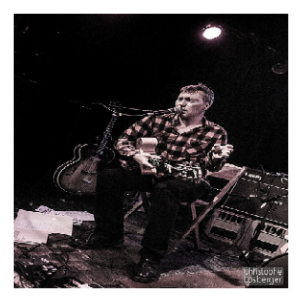

In [702]:
ax = plt.axes([0,0,1,1], frameon=False)

# Then we disable our xaxis and yaxis completely. If we just say plt.axis('off'),
# they are still used in the computation of the image padding.
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Even though our axes (plot region) are set to cover the whole image with [0,0,1,1],
# by default they leave padding between the plotted data and the frame. We use tigher=True
# to make sure the data gets scaled to the full extents of the axes.
plt.autoscale(tight=True)

ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

#plt.imshow(recognized_image/255.)
#plt.imshow(global_var_img/255.)
plt.imshow(img)


In [703]:
best_captions_list 

['Piano someone down',
 'Piano in the ass;',
 'Main squeeze',
 'Flash in the piano',
 'Mad as a box of (soapy) frogs',
 'Flash in the piano',
 'Box in the henhouse (chickenhouse)',
 'A piano for your thoughts',
 'The birds and the squeeze',
 'Accordion to hoyle']

In [698]:
image_topic

'accordion'

In [754]:
def make_image_with_caption( image, caption):
  ax = plt.subplot(1, 1, 1)
  plt.axis('off')
  plt.text( 0.5, -0.1, caption, \
    horizontalalignment='center', verticalalignment='center', \
    transform=ax.transAxes, fontsize=16)
  plt.imshow( image)

  plt.tight_layout()
  plt.savefig('data/image_with_caption.png')
  plt.show()





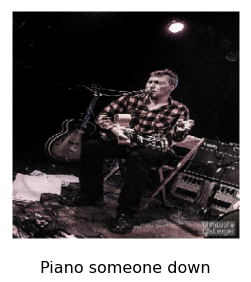

In [755]:
longer_caption = 'Box in the henhouse (chickenhouse) Box in the henhouse (chickenhouse)'
#plot_image( img, longer_caption)

make_image_with_caption( img, best_captions_list[0])